In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import snapfish2
from utils import *
snapfish2.MulFish.default_cols.extend(["Replicate", "FOV"])

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
data_dire = "../../data/takei_nature_2021"
rep_paths = ["4DNFIHF3JCBY.csv", "4DNFIQXONUUH.csv"]
mfr1 = takei_to_mulfish(data_dire, rep_paths)
data_dire = "../../data/jie_aligned_takei_nature_2021"
rep_paths = ["4DNFIVBL8AWT.csv", "4DNFI7G3BWDF.csv"]
mfr2 = takei_to_mulfish(data_dire, rep_paths)

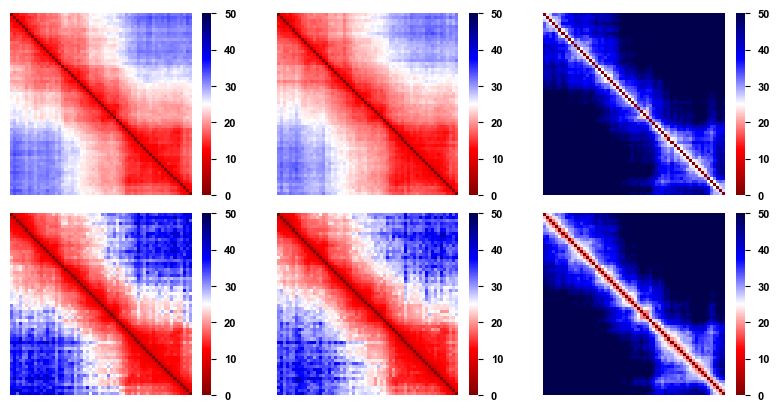

In [4]:
chr_id = "chr14"
chr_df1, arr1 = snapfish2.utils.to_very_wide(mfr1[chr_id])
chr_df2, arr2 = snapfish2.utils.to_very_wide(mfr2[chr_id])

fig, axes = plt.subplots(2, 3, figsize=(8, 4))
for i, ax in enumerate(axes[0]):
    snapfish2.plot.pairwise_heatmap(np.abs(arr1[:,i,:,:]), ax=ax, vmax=50)
for i, ax in enumerate(axes[1]):
    snapfish2.plot.pairwise_heatmap(np.abs(arr2[:,i,:,:]), ax=ax, vmax=50)

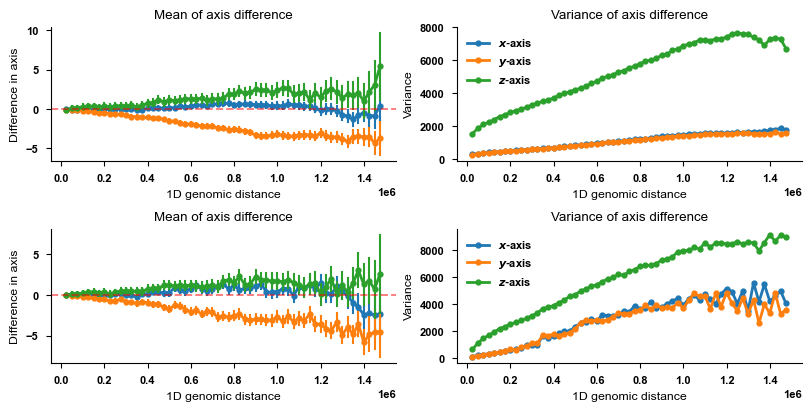

In [5]:
figs = plt.figure(figsize=(8, 4)).subfigures(2, 1)
d1d = chr_df1.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arr1, fig=figs[0])
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arr2, fig=figs[1])

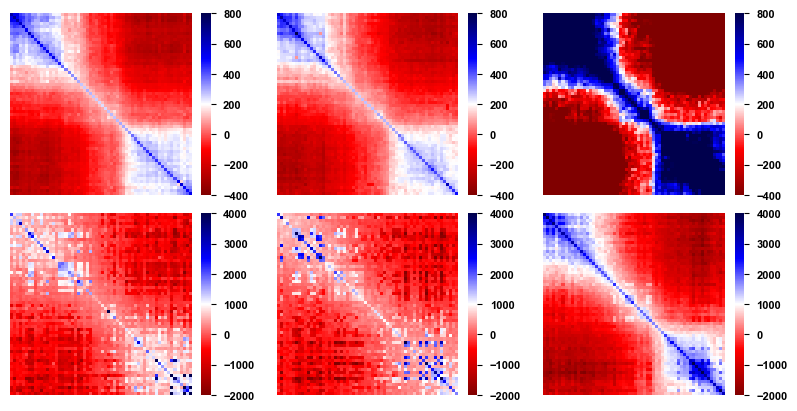

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))
# A = snapfish2.utils.matrixA(len(pd.unique(mfr1[chr_id]["locus"])))
for cov, ax in zip(to_covars(mfr1[chr_id]), axes[0]):
    snapfish2.plot.pairwise_heatmap(cov, ax=ax, vmin=-400, vmax=800)
for cov, ax in zip(to_covars(mfr2[chr_id]), axes[1]):
    snapfish2.plot.pairwise_heatmap(cov, ax=ax, vmin=-2000, vmax=4000)

In [7]:
pd.unique(mfr1.data.Trace_ID)

array(['0_0_1_1_0', '0_0_1_1_1', '0_0_2_1_0', ..., '1_5_36_20_1',
       '1_5_37_20_0', '1_5_38_20_0'], dtype=object)

(<matplotlib.figure.SubFigure at 0x17c34dd30>,
 <Axes3D: xlabel='x (nm)', ylabel='y (nm)', zlabel='z (nm)'>)

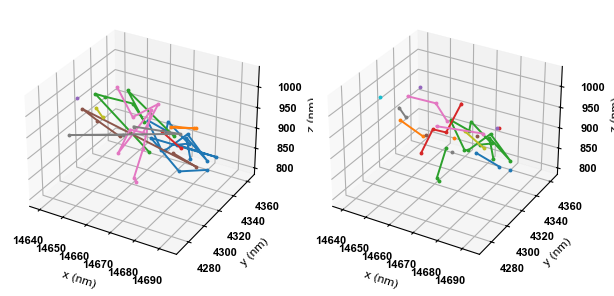

In [8]:
figs = plt.figure(figsize=(6, 3)).subfigures(1, 2)
trace_id = "0_0_4_1_0"
snapfish2.plot.trace(mfr1[("Trace_ID", trace_id)], fig=figs[0])
snapfish2.plot.trace(mfr2[("Trace_ID", trace_id)], fig=figs[1])

### Normalized and outliers

In [15]:
chr_df, arr = snapfish2.utils.to_very_wide(mfr2["chr3"])
i1, j1, i2, j2 = 40, 50, 41, 53
x1, x2 = arr[:,0,i1,j1].copy(), arr[:,0,i2,j2].copy()
# x1[np.abs(x1) > 100] = 0
# x2[np.abs(x2) > 100] = 0
F = np.nanvar(x1, ddof=1)/np.nanvar(x2, ddof=1)
stats.f.cdf(F, np.sum(~np.isnan(x1)), np.sum(~np.isnan(x2)))

2.2258034216912894e-17

In [10]:
narr1 = snapfish2.AxisWiseChi2.preprocess(d1d, arr1, None)
narr2 = snapfish2.AxisWiseChi2.preprocess(d1d, arr2, None)

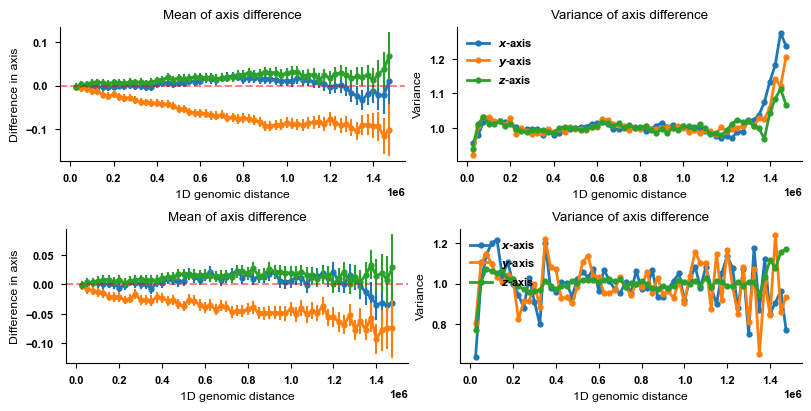

In [11]:
figs = plt.figure(figsize=(8, 4)).subfigures(2, 1)
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, narr1, fig=figs[0])
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, narr2, fig=figs[1])

<Axes: xlabel='# Std (k)', ylabel='% Outliers (k std away)'>

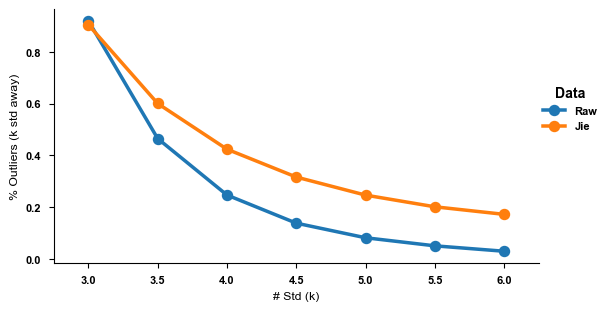

In [12]:
outlier_df = []
for sd in np.arange(3, 6.5, 1/2):
    outlier_df.append([sd, np.sum(np.abs(narr1) > sd), np.sum(np.abs(narr2) > sd)])
id_c, var_c, val_c = "# Std (k)", "Data", "% Outliers (k std away)"
outlier_df = pd.DataFrame(outlier_df, columns=[id_c, "Raw", "Jie"])
outlier_df["Raw"] /= np.sum(~np.isnan(narr1))/100
outlier_df["Jie"] /= np.sum(~np.isnan(narr2))/100
df = outlier_df.melt(id_vars=id_c, value_name=val_c, var_name=var_c)
fig, ax = plt.subplots(figsize=(6, 3))
sns.pointplot(df, x=id_c, y=val_c, hue=var_c, ax=ax)

In [13]:
chr_df = mfr1[chr_id]
coor_cols = ["X", "Y", "Z"]
pivoted = chr_df.pivot_table(
    index="Chrom_Start", 
    columns="Trace_ID", 
    values=coor_cols,
    sort=False
)
cov_df = []
for q in np.linspace(0, 1, 50)[1:]:
    covs = [q]
    for c in coor_cols:
        X = pivoted[c].values.T
        X = X - np.nanmean(X, axis=1)[:,None]
        cov = snapfish2.utils.sample_covar_loh(X)
        covs.append(np.sqrt(np.quantile(np.diag(cov), q)))
    cov_df.append(covs)
x, hue, y = "Quantile", "Axis", "Std"
cov_df = pd.DataFrame(cov_df, columns=[x, "x", "y", "z"])

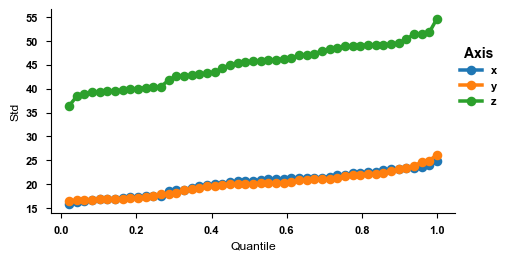

In [14]:
df = cov_df.melt(id_vars=x, value_name=y, var_name=hue)
fig, ax = plt.subplots(figsize=(5, 2.5))
ax = sns.pointplot(df, x=x, y=y, hue=hue, native_scale=True, markersize=5, ax=ax)